In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Prevent truncation of columns
pd.set_option('display.max_colwidth', None)


## Loading data

In [19]:
coffee_beans_df = pd.read_csv('data/Coffee Beans_price_history.csv')
milk_df = pd.read_csv('data/Milk_price_history.csv')
coffee_df = pd.read_csv('data/Coffee_price_history.csv')
goober_df = pd.read_csv('data/Goober Eats_price_history.csv')

## Merge dataframes

In [20]:
combined_df = pd.DataFrame({
    'Day' : coffee_beans_df['Day'],
    'Coffee Beans' : coffee_beans_df['Price'],
    'Milk': milk_df['Price'],
    'Coffee': coffee_df['Price'],
    'Goober Eats': goober_df['Price']
})

combined_df.set_index('Day', inplace=True)
print(combined_df)

     Coffee Beans  Milk  Coffee  Goober Eats
Day                                         
0          120.00  5.00    3.27         1.49
1          121.71  4.73    3.27         1.53
2          123.06  4.78    3.24         1.49
3          121.26  4.81    3.27         1.48
4          122.63  4.84    3.25         1.50
..            ...   ...     ...          ...
360        131.68  6.46    3.60         1.51
361        129.59  6.36    3.60         1.50
362        132.82  6.13    3.57         1.47
363        129.90  6.37    3.56         1.53
364        130.21  6.31    3.59         1.53

[365 rows x 4 columns]


### Correlation Analysis

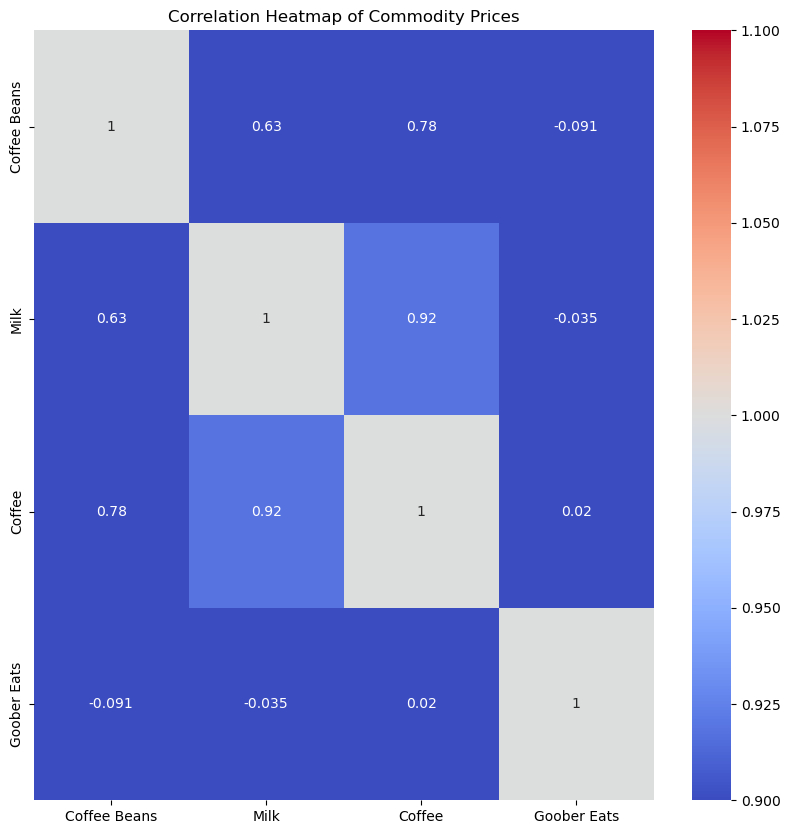

              Coffee Beans      Milk    Coffee  Goober Eats
Coffee Beans      1.000000  0.633497  0.777406    -0.091198
Milk              0.633497  1.000000  0.918088    -0.035368
Coffee            0.777406  0.918088  1.000000     0.020145
Goober Eats      -0.091198 -0.035368  0.020145     1.000000


In [21]:
correlation_matrix = combined_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm', vmin=1, vmax=1)
plt.title("Correlation Heatmap of Commodity Prices")
plt.show()
print(correlation_matrix)

### Price Movements

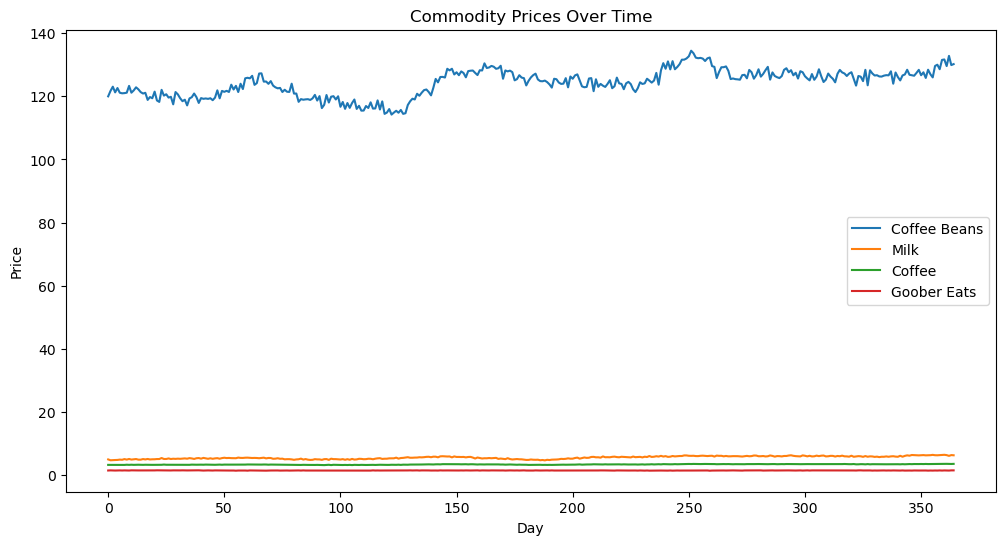

In [22]:
plt.figure(figsize=(12,6))
for column in combined_df.columns:
    plt.plot(combined_df.index, combined_df[column], label=column)
    
plt.title("Commodity Prices Over Time")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

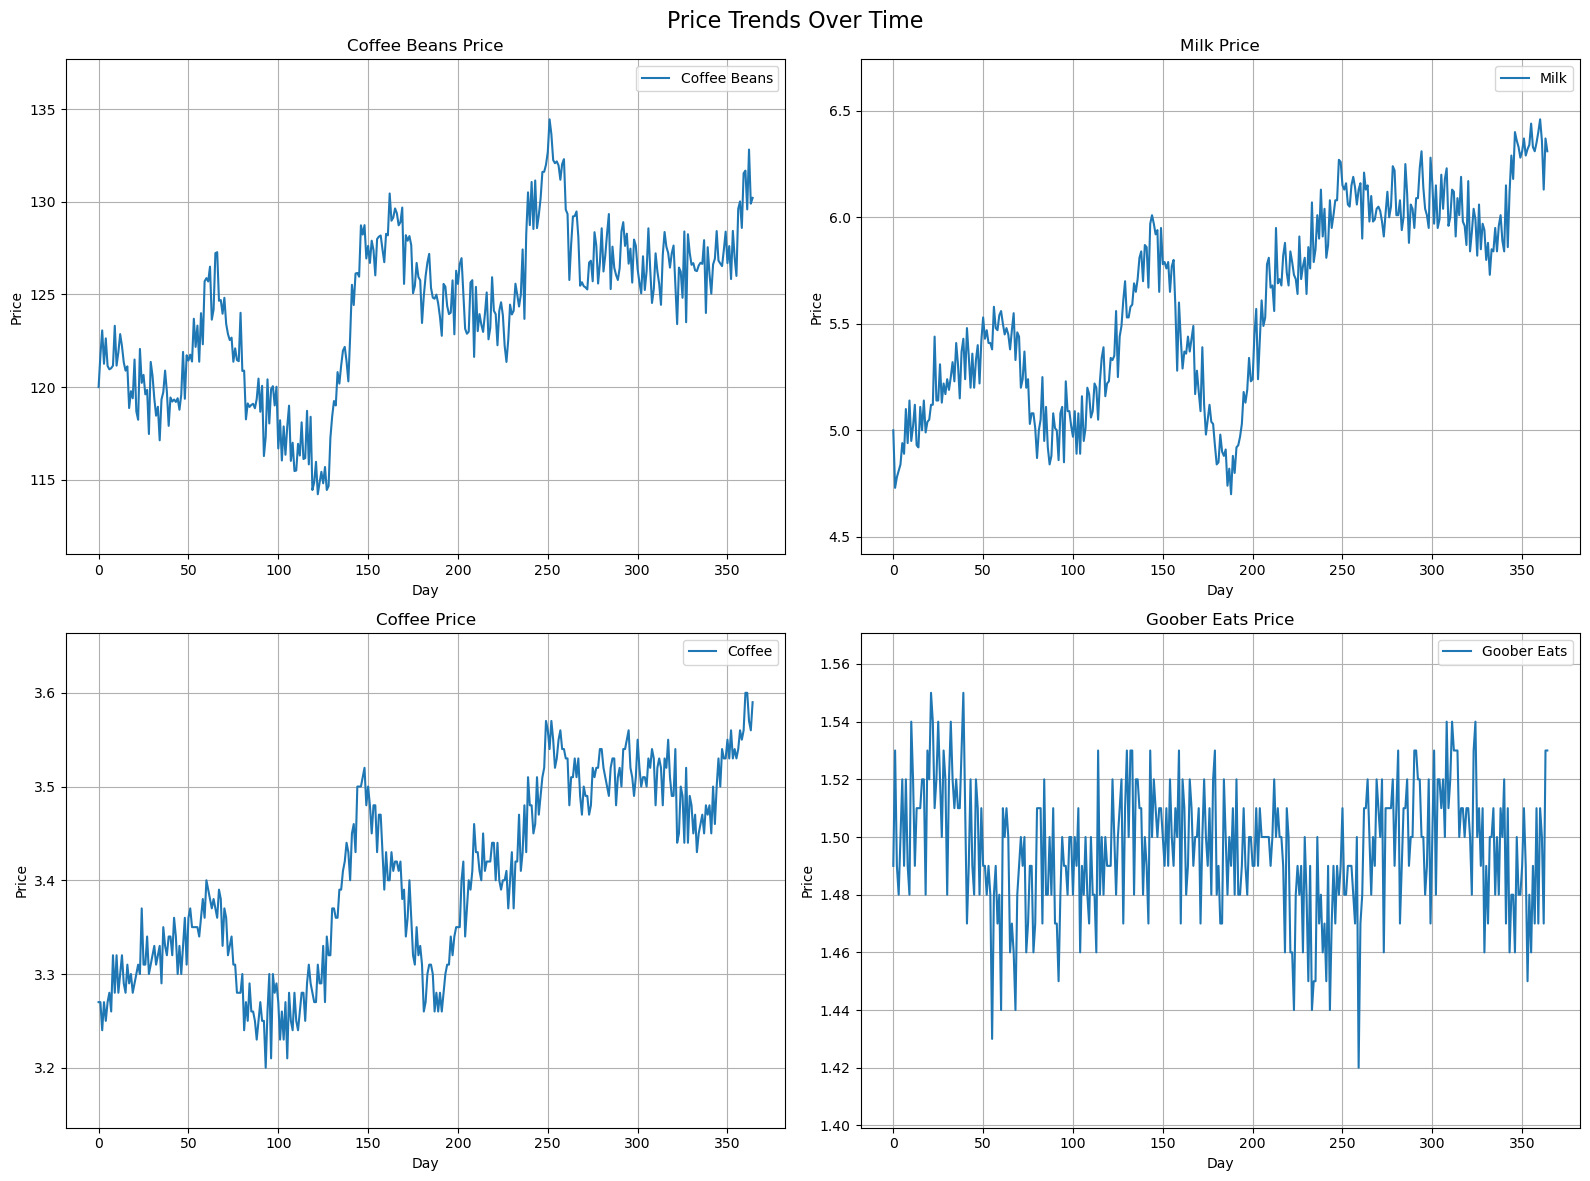


Coffee Beans Price Statistics:
count    365.000000
mean     124.238685
std        4.229048
min      114.220000
25%      121.160000
50%      125.040000
75%      127.240000
max      134.450000
Name: Coffee Beans, dtype: float64
Price Range: 114.22 to 134.45
Total Change: 10.21
Percent Change: 8.51%

Milk Price Statistics:
count    365.000000
mean       5.592658
std        0.454478
min        4.700000
25%        5.190000
50%        5.600000
75%        5.990000
max        6.460000
Name: Milk, dtype: float64
Price Range: 4.70 to 6.46
Total Change: 1.31
Percent Change: 26.20%

Coffee Price Statistics:
count    365.000000
mean       3.401973
std        0.100079
min        3.200000
25%        3.310000
50%        3.400000
75%        3.500000
max        3.600000
Name: Coffee, dtype: float64
Price Range: 3.20 to 3.60
Total Change: 0.32
Percent Change: 9.79%

Goober Eats Price Statistics:
count    365.000000
mean       1.496027
std        0.021885
min        1.420000
25%        1.480000
50%      

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Price Trends Over Time', fontsize=16)

commodities = ['Coffee Beans', 'Milk', 'Coffee', 'Goober Eats']

for i, commodity in enumerate(commodities):
    row = i // 2
    col = i % 2
    axs[row, col].plot(combined_df.index, combined_df[commodity], label=commodity)
    axs[row, col].set_title(f'{commodity} Price')
    axs[row, col].set_xlabel('Day')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()
    axs[row, col].grid(True)

    # Add some padding to the y-axis
    y_min, y_max = axs[row, col].get_ylim()
    y_padding = (y_max - y_min) * 0.1
    axs[row, col].set_ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()
plt.show()

# Additionally, let's print some basic statistics for each commodity
for commodity in commodities:
    print(f"\n{commodity} Price Statistics:")
    print(combined_df[commodity].describe())
    print(f"Price Range: {combined_df[commodity].min():.2f} to {combined_df[commodity].max():.2f}")
    print(f"Total Change: {combined_df[commodity].iloc[-1] - combined_df[commodity].iloc[0]:.2f}")
    print(f"Percent Change: {((combined_df[commodity].iloc[-1] / combined_df[commodity].iloc[0]) - 1) * 100:.2f}%")

## Lag Analysis

  Beans-Coffee Milk-Coffee Coffee-Goober
1     0.790851    0.961589       0.01651
2     0.749105    0.924462      0.022844
3     0.735454    0.928499      0.016067
4      0.71777    0.934118      0.017059
5      0.69463    0.921931      0.031348


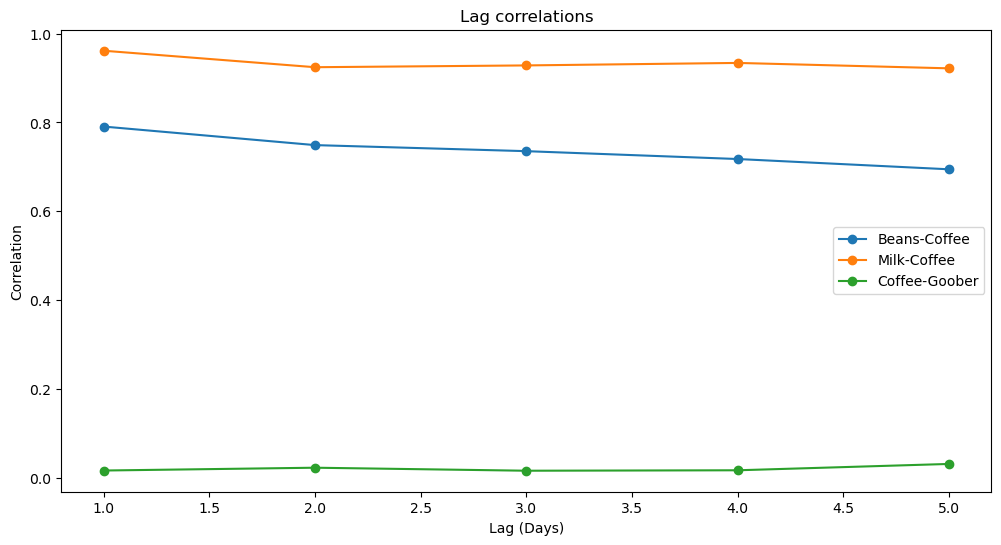

In [27]:
max_lag = 5
lag_correlations = pd.DataFrame(index=range(1, max_lag + 1), 
                                columns=['Beans-Coffee', 'Milk-Coffee', 'Coffee-Goober'])

for lag in range(1, max_lag + 1):
    lag_correlations.loc[lag, 'Beans-Coffee'] = combined_df['Coffee'].corr(combined_df['Coffee Beans'].shift(lag))
    lag_correlations.loc[lag, 'Milk-Coffee'] = combined_df['Coffee'].corr(combined_df['Milk'].shift(lag))
    lag_correlations.loc[lag, 'Coffee-Goober'] = combined_df['Goober Eats'].corr(combined_df['Coffee'].shift(lag))
    
plt.figure(figsize=(12,6))
for column in lag_correlations.columns:
    plt.plot(lag_correlations.index, lag_correlations[column], marker='o', label=column)
plt.title("Lag correlations")
print(lag_correlations)
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation")
plt.legend()
plt.show()

## Kawalski analysis (Lag analysis Xd)
Coffee bean prices could be a good predictor of coffee prices, especially in the short term (1-2 days).
The relationship weakens but remains significant up to 5 days, suggesting a lasting influence.
There's a very strong positive correlation between milk prices and coffee prices.
The correlation is extremely high at all lags, with the strongest at a 1-day lag (0.961589).
The correlation remains above 0.92 for all 5 lags, indicating a consistent, strong relationship.
Milk prices appear to be an excellent predictor of coffee prices across all tested time lags.
The relationship is stronger than that of coffee beans, which is somewhat surprising and may warrant further investigation.
The consistency across lags suggests that milk prices have a sustained influence on coffee prices

Both coffee beans and milk prices are strongly correlated with future coffee prices.
Milk prices show an surprisingly high correlation with coffee prices, even higher than coffee beans. This could be due to:
a) Milk being a significant cost factor in coffee drinks (e.g., lattes, cappuccinos).
b) Possible common factors affecting both milk and coffee prices (e.g., overall dairy industry trends, café industry demand).


The lag effect is most pronounced for coffee beans, showing a clear decrease in correlation over time. This suggests that recent bean prices are more relevant for predicting coffee prices than older ones.
Milk prices show a remarkably consistent high correlation across all lags. This could indicate that milk prices have a more stable, long-term relationship with coffee prices.

## Granger Causality Test

/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hackathon/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecate

             Coffee Beans    Milk  Coffee Goober Eats
Coffee Beans          NaN  0.1796     0.0       0.344
Milk                  0.0     NaN     0.0      0.6826
Coffee                0.0     0.0     NaN      0.7969
Goober Eats        0.5203  0.0944  0.3843         NaN


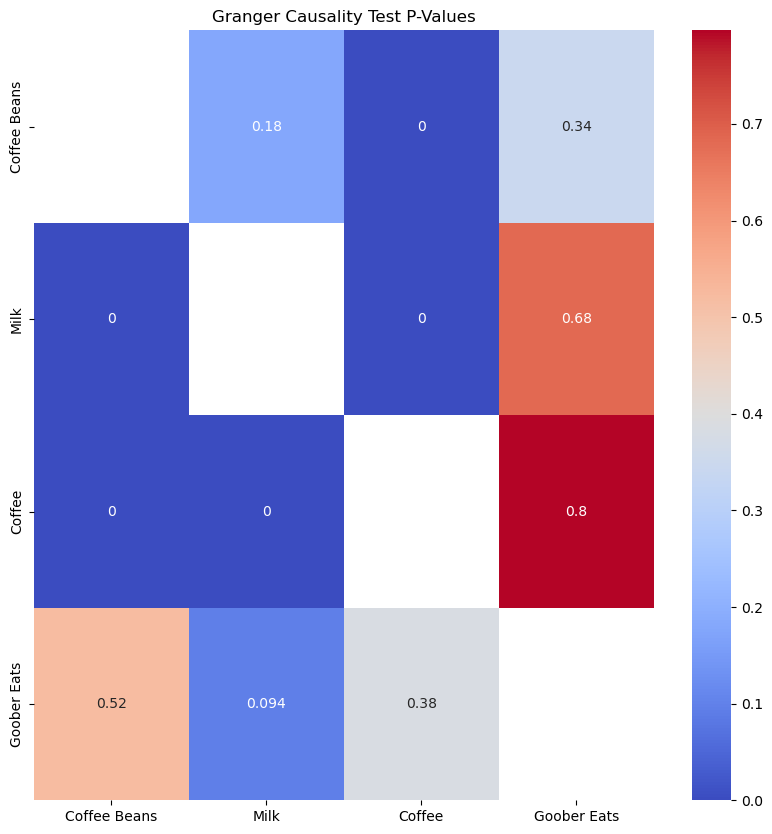

In [25]:
max_lag = 5
variables = ['Coffee Beans', 'Milk', 'Coffee', 'Goober Eats']
results = pd.DataFrame(index=variables, columns=variables)

for cause in variables:
    for effect in variables:
        if cause != effect:
            test_result = grangercausalitytests(combined_df[[effect, cause]], max_lag, verbose=False)
            p_values = [round(test_result[i + 1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
            min_p_value = np.min(p_values)
            results.loc[cause, effect] = min_p_value

plt.figure(figsize=(10, 10))
print(results)
sns.heatmap(results.astype(float), annot=True, cmap='coolwarm')
plt.title("Granger Causality Test P-Values")
plt.show()

#### Result interpretation

Coffee Beans:

Granger-causes Coffee (p-value = 0.0)
Does not Granger-cause Milk (p-value = 0.1796)
Does not Granger-cause Goober Eats (p-value = 0.344)


Milk:

Granger-causes Coffee Beans (p-value = 0.0)
Granger-causes Coffee (p-value = 0.0)
Does not Granger-cause Goober Eats (p-value = 0.6826)


Coffee:

Granger-causes Coffee Beans (p-value = 0.0)
Granger-causes Milk (p-value = 0.0)
Does not Granger-cause Goober Eats (p-value = 0.7969)


Goober Eats:

Does not Granger-cause Coffee Beans (p-value = 0.5203)
Granger-causes Milk (p-value = 0.0944, close to significant)
Does not Granger-cause Coffee (p-value = 0.3843)

(Lower p value, the better)

This basically means, Coffe beans causes changes in coffe price, but does nto affect milk prices or goober eats
Milk causes a change in price to coffee beans and coffee
Coffee causes a change in price of coffee beans and milk

Goober eats somehow has some effect on milk?

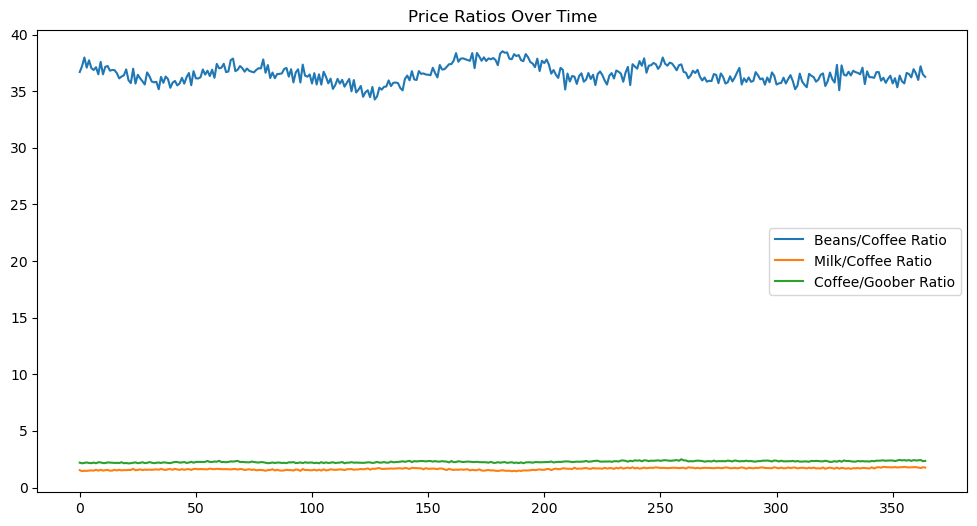

In [29]:
combined_df['Beans/Coffee Ratio'] = combined_df['Coffee Beans'] / combined_df['Coffee']
combined_df['Milk/Coffee Ratio'] = combined_df['Milk'] / combined_df['Coffee']
combined_df['Coffee/Goober Ratio'] = combined_df['Coffee'] / combined_df['Goober Eats']

plt.figure(figsize=(12,6))
for ration in ['Beans/Coffee Ratio', 'Milk/Coffee Ratio', 'Coffee/Goober Ratio']:
    plt.plot(combined_df.index, combined_df[ration], label=ration)
    
plt.title("Price Ratios Over Time")
plt.legend()
plt.show()

PearsonRResult(statistic=0.7774058159858941, pvalue=4.3680614936646525e-75)


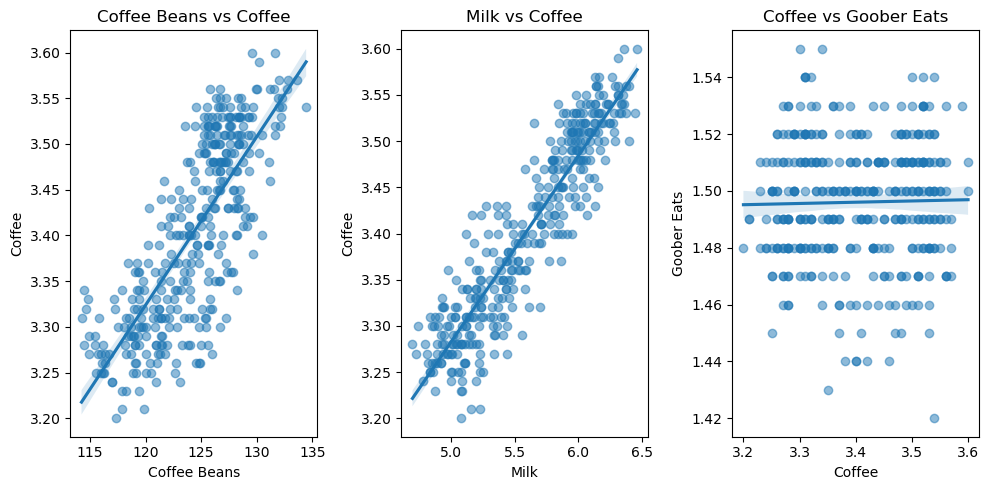

In [42]:
plt.figure(figsize=(10,5))
for i, (x,y) in enumerate([('Coffee Beans', 'Coffee'), ('Milk', 'Coffee'), ('Coffee', 'Goober Eats')]):
    plt.subplot(1, 3, i+1)
    sns.regplot(x=combined_df[x], y=combined_df[y], scatter_kws={'alpha':0.5})
    plt.title(f"{x} vs {y}")
print(stats.pearsonr(combined_df['Coffee Beans'], combined_df['Coffee']))
plt.tight_layout()
plt.show()

### Multiple regression

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = combined_df[['Coffee Beans', 'Milk']]
y = combined_df['Coffee']

model = LinearRegression()
model.fit(X, y)
r2 = r2_score(y, model.predict(X))
print(f"R-Squared for Coffee Price Predictions: {r2:.4f}")
print(f"Coefficients: Coffee Beans: {model.coef_[0]:.4f}, Milk: {model.coef_[1]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

R-Squared for Coffee Price Predictions: 0.9069
Coefficients: Coffee Beans: 0.0077, Milk: 0.1565
Intercept: 1.5649


R Squared = This means that about 90.69% of the variability in coffee prices can be explained by coffee bean prices and milk prices.

Coefficients: Coffee Beans (0.0077): For every $1 increase in coffee bean price, the coffee price is expected to increase by $0.0077, holding milk price constant.


Milk (0.1565): For every $1 increase in milk price, the coffee price is expected to increase by $0.1565, holding coffee bean price constant.


This suggests that milk prices have a much larger direct impact on coffee prices than coffee bean prices

Intercept (1.5649):
This is the expected coffee price when both coffee bean and milk prices are zero. In practice, this often doesn't have a meaningful interpretation.

This then forms the equation:
Coffee Price = 1.5649 + 0.0077 * (Coffee Bean Price) + 0.1565 * (Milk Price)

## Percent change correlation

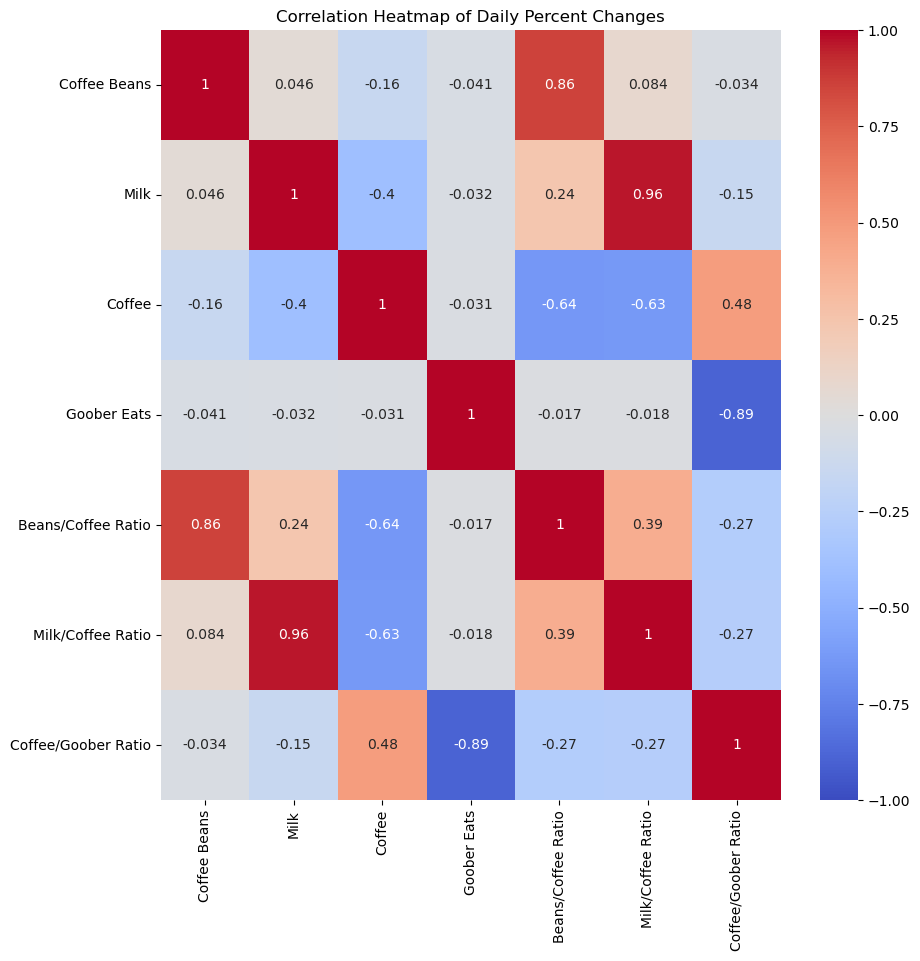

                     Coffee Beans      Milk    Coffee  Goober Eats  \
Coffee Beans             1.000000  0.045578 -0.155324    -0.041343   
Milk                     0.045578  1.000000 -0.397025    -0.032436   
Coffee                  -0.155324 -0.397025  1.000000    -0.030629   
Goober Eats             -0.041343 -0.032436 -0.030629     1.000000   
Beans/Coffee Ratio       0.858347  0.241897 -0.640048    -0.016539   
Milk/Coffee Ratio        0.083955  0.963503 -0.628018    -0.018277   
Coffee/Goober Ratio     -0.033794 -0.149284  0.477658    -0.892501   

                     Beans/Coffee Ratio  Milk/Coffee Ratio  \
Coffee Beans                   0.858347           0.083955   
Milk                           0.241897           0.963503   
Coffee                        -0.640048          -0.628018   
Goober Eats                   -0.016539          -0.018277   
Beans/Coffee Ratio             1.000000           0.391717   
Milk/Coffee Ratio              0.391717           1.000000   
Coffe

In [48]:
pct_change = combined_df.pct_change().dropna()  # Calculate the percent change for each day
pct_change = pct_change.corr()  # Calculate the correlation between the percent changes

plt.figure(figsize=(10, 10))
sns.heatmap(pct_change, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Daily Percent Changes")
plt.show()
print(pct_change)

The strong correlations between price ratios and their numerators (e.g., Beans/Coffee Ratio with Coffee Beans) are expected mathematically.


The Coffee/Goober Ratio's strong negative correlation with Goober Eats (-0.892501) and positive correlation with Coffee (0.477658) make sense mathematically and indicate that this ratio is more sensitive to Goober Eats price changes than Coffee price changes.


Coffee Beans and Milk: Weak positive correlation (0.045578)
Coffee Beans and Coffee: Weak negative correlation (-0.155324)
Milk and Coffee: Moderate negative correlation (-0.397025)
Goober Eats has very weak correlations with all other commodities


Beans/Coffee Ratio strongly correlates with Coffee Beans (0.858347)
Milk/Coffee Ratio very strongly correlates with Milk (0.963503)
Coffee/Goober Ratio strongly negatively correlates with Goober Eats (-0.892501)


The negative correlation between Milk and Coffee price changes (-0.397025) is interesting. It suggests that when milk prices increase, coffee prices tend to decrease slightly, or vice versa. This could indicate some form of price balancing in the market.


Coffee Beans price changes have a weak negative correlation with Coffee price changes (-0.155324). This is somewhat counterintuitive and might suggest that short-term changes in bean prices don't immediately translate to coffee prices.

## Summary Stats

In [49]:
summary_stats = combined_df.describe()
print(summary_stats)

       Coffee Beans        Milk      Coffee  Goober Eats  Beans/Coffee Ratio  \
count    365.000000  365.000000  365.000000   365.000000          365.000000   
mean     124.238685    5.592658    3.401973     1.496027           36.522744   
std        4.229048    0.454478    0.100079     0.021885            0.796438   
min      114.220000    4.700000    3.200000     1.420000           34.266467   
25%      121.160000    5.190000    3.310000     1.480000           35.950000   
50%      125.040000    5.600000    3.400000     1.500000           36.493976   
75%      127.240000    5.990000    3.500000     1.510000           37.030488   
max      134.450000    6.460000    3.600000     1.550000           38.529052   

       Milk/Coffee Ratio  Coffee/Goober Ratio  
count         365.000000           365.000000  
mean            1.641765             2.274473  
std             0.091431             0.074245  
min             1.432927             2.129032  
25%             1.564179             2.

## Correlation Significance Test

In [51]:
def correlation_sig(x, y, alpha=0.05):
    corr, p = stats.pearsonr(x, y)
    print(f"Correaltion: {corr:.4f}")
    print(f"P-value: {p:.4f}")
    if p < alpha:
        print("Correlation is significant")
    else:
        print("Correlation is not significant")
    print()
    
print("Correlation between Coffee Beans and Coffee:")
correlation_sig(combined_df['Coffee Beans'], combined_df['Coffee'])
print("Correlation between Milk and Coffee:")
correlation_sig(combined_df['Milk'], combined_df['Coffee'])
print("Correlation between Coffee and Goober Eats:")
correlation_sig(combined_df['Coffee'], combined_df['Goober Eats'])

Correlation between Coffee Beans and Coffee:
Correaltion: 0.7774
P-value: 0.0000
Correlation is significant

Correlation between Milk and Coffee:
Correaltion: 0.9181
P-value: 0.0000
Correlation is significant

Correlation between Coffee and Goober Eats:
Correaltion: 0.0201
P-value: 0.7013
Correlation is not significant

